In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "happiness_over_countries"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import string
import unicodedata
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
import re
from pyspark.conf import SparkConf
from pyspark.sql import functions as F
import string
import csv
from pyspark.sql.types import StringType, TimestampType
from pyspark.sql.types import ArrayType

In [3]:
spark = SparkSession.builder\
    .master("local[*]")\
    .appName("nlp")\
    .config("spark.executor.memory", "32g")\
    .config("spark.driver.memory", "32g")\
    .config("spark.memory.offHeap.enabled",True) \
    .config("spark.memory.offHeap.size","16g")\
    .config("spark.debug.maxToStringFields","200")\
    .getOrCreate()

In [4]:
import tarfile
from six.moves import urllib
          

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/hadiaskari1981/sentiment_analysis/master/"
DATASETS_PATH = os.path.join("datasets")
DOWNLOAD_URL = DOWNLOAD_ROOT + "datasets/datasets.tar.gz"
TWEETS_PATH = os.path.join("datasets", "tweets")


def fetch_housing_data(download_url=DOWNLOAD_URL, datasets_path=DATASETS_PATH):
    if not os.path.isdir(datasets_path):
        os.makedirs(datasets_path)
    tgz_path = os.path.join(datasets_path, "datasets.tar.gz")
    urllib.request.urlretrieve(download_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=datasets_path)
    housing_tgz.close()


In [5]:
def load_data(path, join):
    csv_path = os.path.join(path,join)
    return spark.read.csv(csv_path, inferSchema=True, encoding = 'utf8', header=True)

In [ ]:
fetch_housing_data()

In [ ]:
# Remove https in the text
def remove_https(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    return text
udfhttps=udf(lambda text: remove_https(text), StringType())


In [ ]:
def normalizeData(text):    
    text = unicodedata.normalize('NFKD', str(text))
    text = text.replace(r'\n', '')
    text = ' '.join(text.split())
    replace_punctuation = str.maketrans(string.punctuation,' '*len(string.punctuation))
    text = text.translate(replace_punctuation)
    text = text.encode('ASCII', 'ignore')
    text = text.decode('unicode_escape')
    text = ''.join([i for i in text if not i.isdigit()])
    return text

udfNormalizeData=udf(lambda text: normalizeData(text), StringType())



In [ ]:
LATIN_1_CHARS = (
    (' xe2 x80 x99', "'"),
    (' xc3 xa9', 'e'),
    (' xe2 x80 x90', '-'),
    (' xe2 x80 x91', '-'),
    (' xe2 x80 x92', '-'),
    (' xe2 x80 x93', '-'),
    (' xe2 x80 x94', '-'),
    (' xe2 x80 x94', '-'),
    (' xe2 x80 x98', "'"),
    (' xe2 x80 x9b', "'"),
    (' xe2 x80 x9c', '"'),
    (' xe2 x80 x9c', '"'),
    (' xe2 x80 x9d', '"'),
    (' xe2 x80 x9e', '"'),
    (' xe2 x80 x9f', '"'),
    #(' xe2 x80 xa6', '...'),
    (' xe2 x80 xa6', ''),
    (' xe2 x80 xb2', "'"),
    (' xe2 x80 xb3', "'"),
    (' xe2 x80 xb4', "'"),
    (' xe2 x80 xb5', "'"),
    (' xe2 x80 xb6', "'"),
    (' xe2 x80 xb7', "'"),
    (' xe2 x81 xba', "+"),
    (' xe2 x81 xbb', "-"),
    (' xe2 x81 xbc', "="),
    (' xe2 x81 xbd', "("),
    (' xe2 x81 xbe', ")"),
    (' xe2 x80 xa7', "."),
    ('.', " "),
)
def clean_latin1(data):
    for _hex, _char in LATIN_1_CHARS:
        data = data.replace(_hex, _char)
    return data

udfDecoding=udf(lambda text: clean_latin1(text), StringType())

In [ ]:
def lower_words(df):
    fields = df.schema.fields
    stringFields = filter(lambda f: isinstance(f.dataType, StringType), fields)
    nonStringFields = map(lambda f: col(f.name), filter(lambda f: not isinstance(f.dataType, StringType), fields))
    stringFieldsTransformed = map(lambda f: lower(col(f.name)).alias(f.name), stringFields) 
    allFields = [*nonStringFields, *stringFieldsTransformed]
    df = df.select(allFields)
    return df

In [ ]:
def regexTokenizer_StopWordsRemover(df, inputCol, outputCol1, outputCol2, ):
    # the input od the stop words is the outputCol1 from tokenizer
    # inputCol and outputCol should be in string format
    regexTokenizer = RegexTokenizer(minTokenLength= 3, inputCol=inputCol, outputCol=outputCol1, pattern="\\W")
    df = regexTokenizer.transform(df)
    remover = StopWordsRemover(inputCol=outputCol1, outputCol=outputCol2)
    df = remover.transform(df).drop(inputCol, outputCol1)
    return df

In [ ]:
def remove_emoji(df, inputCol, outputCol):
    with open(os.path.join(DATASETS_PATH,'emoji.txt'), 'r') as f:
        first_list=f.read().strip().splitlines()

    second_list = []
    for item in first_list:
        x = item.split('\\')
        second_list.append(x)

    third_list = []
    for item in second_list:
        new_list = []
        for e in item:
            if e not in (''):
                new_list.append(e)
        third_list.append(new_list)

    fourth_list = [item for sublist in third_list for item in sublist]

    emojies = []
    for word in fourth_list:   #for each word in line.split()
        if word not in emojies:    #if a word isn't in line.split            
            emojies.append(word.lower())

    remover = StopWordsRemover(inputCol=inputCol, outputCol=outputCol, stopWords=emojies)
    df = remover.transform(df).drop(inputCol).withColumnRenamed(outputCol, inputCol)
    return df                                                     

In [ ]:
def avg_happiness_of_words(df,nameCol_to_explode):
    h_avg = sc.textFile(os.path.join(DATASETS_PATH, "Data_Set_S1.txt"))\
           .mapPartitions(lambda line: csv.reader(line,delimiter='\t', quotechar='"'))\
           .filter(lambda line: len(line)>=2 and line[0]!= 'word')\
           .toDF(["word", "happiness_rank", "happiness_average",\
                  "happiness_standard_deviation", "twitter_rank",\
                  "google_rank", "nyt_rank", "lyrics_rank"])

    happiness_words = h_avg.select('word').collect()
    happiness_average = h_avg.select('happiness_average').collect()
    happiness_words = [str(row.word) for row in happiness_words]
    happiness_average = [float(row.happiness_average) for row in happiness_average]
    
    nameCols = df.columns
    df=df.withColumn('row_index', F.monotonically_increasing_id()).select(["row_index"]+nameCols)
    
    df_explode = df.withColumn("elements", explode(nameCol_to_explode))
    df_explode = df_explode.toPandas()
    
    for pos, word in enumerate(happiness_words):
        if happiness_average[pos] <= 3.5 or happiness_average[pos] >=6.5 :
            df_explode.loc[df_explode.elements == word, 'happiness_score'] = happiness_average[pos]
    
    df_explode = df_explode.dropna()
    
    sqlCtx = SQLContext(sc)
    df_explode=sqlCtx.createDataFrame(df_explode)
        
    df_explode = df_explode.orderBy("row_index").groupBy("row_index" ).agg(collect_list("happiness_score"))
    df_explode = df_explode.select(col("row_index").alias("row_index"),\
                         col("collect_list(happiness_score)").alias("happiness_score"))
    
    df = df.join(df_explode, on='row_index', how = 'inner').sort('row_index').drop('row_index')
    
    def mean_list(x):
        summation = 0.00
        for val in x:
            
            summation = float(summation) + float(val)
        return [float(summation)/float(len(x))]

    mean_list_udf = udf(lambda y: mean_list(y), ArrayType(FloatType()))
    
    df = df.withColumn('happiness_avg', mean_list_udf('happiness_score'))
    df= df.withColumn("happiness_avg", explode('happiness_avg'))

    return df   
    

In [ ]:
for i in range(1,36):
    print(i)
    filename = str(i)+'.csv'
    tweets = load_data(TWEETS_PATH, filename)
    tweets = tweets.selectExpr("_c0 as date", "_c1 as text")
    tweets = tweets.withColumn("text", udfhttps(tweets["text"]))
    tweets = tweets.withColumn("text", udfNormalizeData(tweets["text"]))
    tweets = tweets.withColumn("text", udfDecoding(tweets["text"]))
    tweets= lower_words(tweets)
    tweets= regexTokenizer_StopWordsRemover(tweets, 'text', 'words_','words')
    tweets = remove_emoji(tweets, "words","words_")
    #tweets.show(2)
    if i == 1:
        tweets = avg_happiness_of_words(tweets, 'words')
        tweets_final = tweets
        
    else:
        tweets = avg_happiness_of_words(tweets, 'words')
        tweets_final = tweets_final.union(tweets)

In [ ]:
tweets_final.repartition(1).write.json(os.path.join(DATASETS_PATH,'tweets_happiness'))

## Start

**The all previous processes have been saved in tweets_happiness.json**

In [28]:
tweets_happiness = spark.read.json('./datasets/tweets_happiness/tweets_happiness.json')

In [29]:
tweets_happiness = tweets_happiness.withColumn('date' , regexp_replace('date', 't', ' '))
tweets_happiness = tweets_happiness.withColumn('date' , regexp_replace('date', '\.', ' '))

In [30]:
split_col = pyspark.sql.functions.split(tweets_happiness['date'], ' ')
tweets_happiness = tweets_happiness.withColumn('time', split_col.getItem(1))
tweets_happiness = tweets_happiness.withColumn('date', split_col.getItem(0))

In [34]:
tweets_happiness = tweets_happiness.withColumn('hour_min',\
                                               F.regexp_extract("time", pattern='(\d+):(\d+)', idx=0))
tweets_happiness = tweets_happiness.withColumn('hour',\
                                               F.regexp_extract("time", pattern='(\d+)', idx=0))

tweets_happiness.show(5)

+----------+-------------+--------------------+--------------------+--------+--------+----+
|      date|happiness_avg|     happiness_score|               words|    time|hour_min|hour|
+----------+-------------+--------------------+--------------------+--------+--------+----+
|2018-06-15|         7.61|         [7.2, 8.02]|[good, work, swan...|11:23:49|   11:23|  11|
|2018-06-15|         7.51|[7.66, 7.32, 7.34...|[izzah, raya, mes...|11:23:49|   11:23|  11|
|2018-06-15|     8.033334|   [8.02, 8.3, 7.78]|[fifaworldcup, ha...|11:23:49|   11:23|  11|
|2018-06-15|         8.02|        [8.02, 8.02]|[advbarryroux, ro...|11:23:49|   11:23|  11|
|2018-06-15|         7.02|              [7.02]|[wired, rare, soc...|11:23:49|   11:23|  11|
+----------+-------------+--------------------+--------------------+--------+--------+----+
only showing top 5 rows



In [9]:
#tweets_happiness.select('time').filter(col("date").like("2018-06-21%")).collect()

In [49]:
tweets_happiness_min = tweets_happiness.withColumn('date' , (concat(col("date"), lit(" "), col("hour_min")))).\
                    drop('happiness_score', 'words', 'time', 'hour_min', 'hour')
tweets_happiness_hour = tweets_happiness.withColumn('date' , (concat(col("date"), lit(" "), col("hour")))).\
                    drop('happiness_score', 'words', 'time', 'hour_min','hour')

tweets_happiness_second = tweets_happiness.withColumn('date' , (concat(col("date"), lit(" "), col("time")))).\
                    drop('happiness_score', 'words', 'time', 'hour_min','hour')

In [50]:
def avg_happiness_over_date(df, groupby_col, happiness_avg_over_words_col):
    nameCols = df.columns
    #df = df.withColumn('row_index', F.monotonically_increasing_id()).select(['row_index']+nameCols)
    df = df.groupBy(groupby_col).agg(collect_list(happiness_avg_over_words_col).\
                                     alias("happiness_avg"))
    def mean_list(x):
        summation = 0.00
        for val in x:
            #if val< 4 or val > 6:
            summation = float(summation) + float(val)
        return [float(summation)/float(len(x))]

    mean_list_udf = udf(lambda y: mean_list(y), ArrayType(FloatType()))

    df = df.withColumn('happiness_avg', mean_list_udf('happiness_avg'))
    df = df.withColumn("happiness_avg", explode('happiness_avg'))
    
    return df

In [51]:
tweets_happiness_second = avg_happiness_over_date(tweets_happiness_second, 'date', 'happiness_avg')
tweets_happiness_min = avg_happiness_over_date(tweets_happiness_min, 'date', 'happiness_avg')
tweets_happiness_hour = avg_happiness_over_date(tweets_happiness_hour, 'date', 'happiness_avg')

In [52]:
tweets_happiness_second = tweets_happiness_second.sort('date')
tweets_happiness_min = tweets_happiness_min.sort('date')
tweets_happiness_hour = tweets_happiness_hour.sort('date')

In [53]:
#tweets_happiness = tweets_happiness.sort('date').dropna()

In [54]:
#tweets_happiness.where("date is null").show()

In [55]:
tweets_happiness_second.createOrReplaceTempView('tweets_happiness_second')
tweets_second = spark.sql('select row_number() over (order by "date") as num, * from tweets_happiness_second')

tweets_happiness_min.createOrReplaceTempView('tweets_happiness_min')
tweets_min = spark.sql('select row_number() over (order by "date") as num, * from tweets_happiness_min')

tweets_happiness_hour.createOrReplaceTempView('tweets_happiness_hour')
tweets_hour = spark.sql('select row_number() over (order by "date") as num, * from tweets_happiness_hour')

In [56]:
tweets_second = tweets_second.toPandas()
tweets_min = tweets_min.toPandas()
tweets_hour = tweets_hour.toPandas()

In [65]:
tweets_hour.head(5)

,num,date,happiness_avg
0,1,2018-06-15 04,7.233305
1,2,2018-06-15 05,7.190453
2,3,2018-06-15 06,7.361278
3,4,2018-06-15 07,7.303745
4,5,2018-06-15 08,7.311091


Saving figure 1


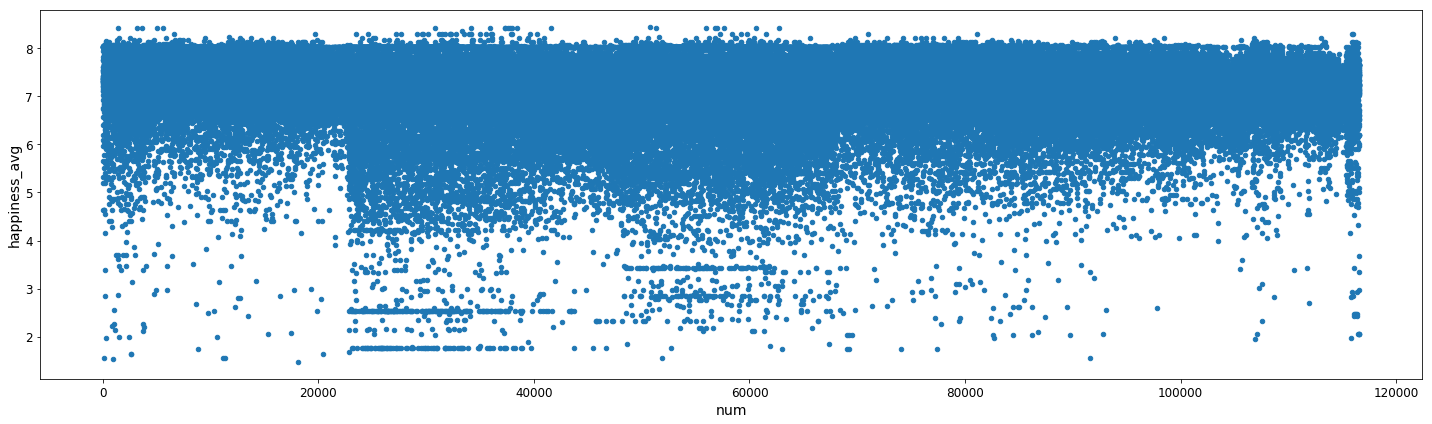

In [58]:
ax = tweets_second.plot(kind="scatter", x="num", y="happiness_avg", figsize=(20,6))
save_fig("1")
plt.show()

Saving figure 1


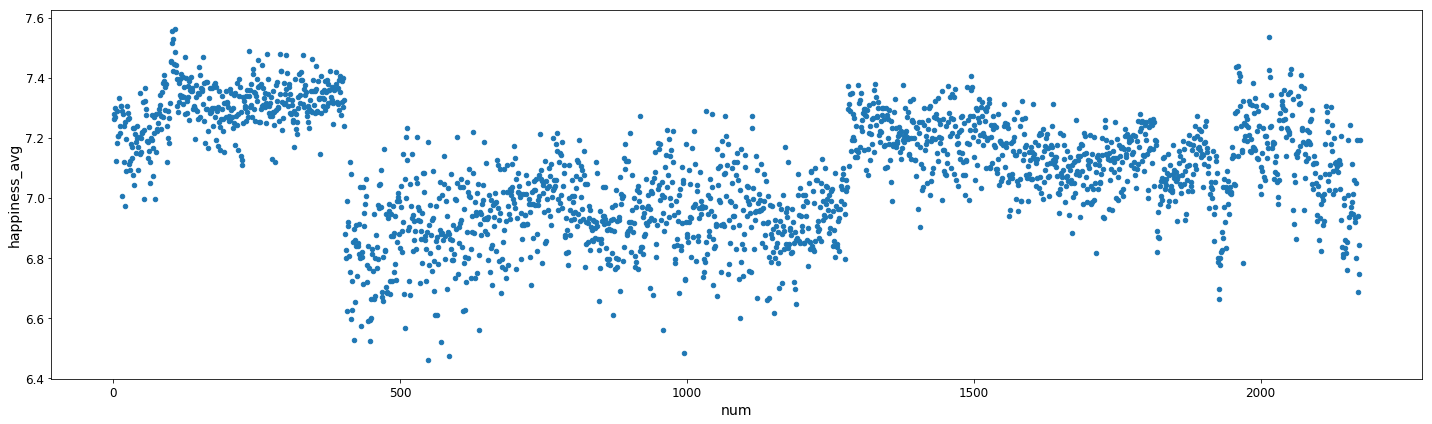

In [59]:
ax = tweets_min.plot(kind="scatter", x="num", y="happiness_avg", figsize=(20,6))
save_fig("1")
plt.show()

In [62]:
tweets_hour.count()

num              72
date             72
happiness_avg    72
dtype: int64

Saving figure 1


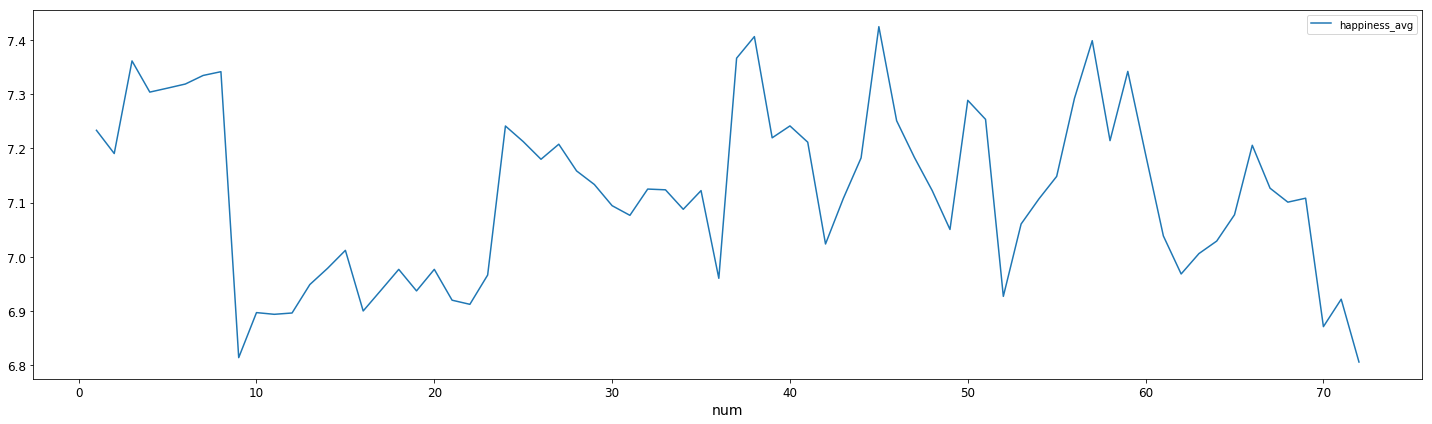

In [61]:
ax = tweets_hour.plot(kind="line", x="num", y="happiness_avg", figsize=(20,6))
save_fig("1")
plt.show()

In [21]:
from ggplot import *

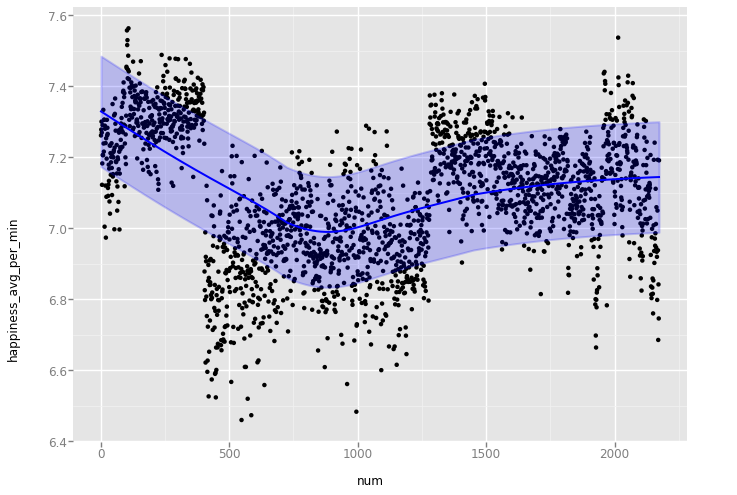

<ggplot: (8728983428847)>

In [27]:
p = ggplot(aes(x='num', y='happiness_avg_per_min'), data=tweets_h)
p+geom_point()+stat_smooth(color='blue', size = 2, method = 'loess' )